In [5]:
# Importing necessary libraries
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
from shapely.geometry import Point
import requests
from zipfile import ZipFile
from io import BytesIO
from io import BytesIO, TextIOWrapper
from zipfile import ZipFile
import urllib.request
import csv
from shapely.geometry import Point
import geopandas as gpd

# Check if sr_util is available in the current directory
import os
if not os.path.isfile('sr_util.py'):
    raise ImportError("sr_util.py not found. Please ensure it is in the same directory as this notebook.")

# Importing custom functions from sr_util.py
from sr_util import run_sr




In [47]:

VOC, NOx, NH3, SOx, PM2_5 = [], [], [], [], []
height, diam, temp, velocity = [], [], [],  []
coords = []

def add_record(row):
    """ Process one row of the emissions file """
    pol = row[12] # The pollutant is in the 13th column of the CSV file
                  # (In Python, the first column is called column 0.)
    emis = row[13] # We are only extracting annual total emissions here.
                   # If monthly emissions are reported, we'll miss them.
                   # Emissions are short tons/year.
    if emis == '': return
    if pol in ['VOC', 'VOC_INV', 'XYL', 'TOL', 'TERP', 'PAR', 'OLE', 'NVOL', 'MEOH',
               'ISOP', 'IOLE', 'FORM', 'ETOH', 'ETHA', 'ETH', 'ALD2', 'ALDX', 'CB05_ALD2',
               'CB05_ALDX', 'CB05_BENZENE', 'CB05_ETH', 'CB05_ETHA', 'CB05_ETOH',
               'CB05_FORM', 'CB05_IOLE', 'CB05_ISOP', 'CB05_MEOH', 'CB05_OLE', 'CB05_PAR',
               'CB05_TERP', 'CB05_TOL', 'CB05_XYL', 'ETHANOL', 'NHTOG', 'NMOG', 'VOC_INV']:
        VOC.append(float(emis))
        NOx.append(0)
        NH3.append(0)
        SOx.append(0)
        PM2_5.append(0)
    elif pol in ['PM25-PRI', 'PM2_5', 'DIESEL-PM25', 'PAL', 'PCA', 'PCL', 'PEC', 'PFE', 'PK',
                'PMG', 'PMN', 'PMOTHR', 'PNH4', 'PNO3', 'POC', 'PSI', 'PSO4', 'PTI']:
        VOC.append(0)
        NOx.append(0)
        NH3.append(0)
        SOx.append(0)
        PM2_5.append(float(emis))
    elif pol in ['NOX', 'HONO', 'NO', 'NO2']:
        VOC.append(0)
        NOx.append(float(emis))
        NH3.append(0)
        SOx.append(0)
        PM2_5.append(0)
    elif pol == 'NH3':
        VOC.append(0)
        NOx.append(0)
        NH3.append(float(emis))
        SOx.append(0)
        PM2_5.append(0)
    elif pol == 'SO2':
        VOC.append(0)
        NOx.append(0)
        NH3.append(0)
        SOx.append(float(emis))
        PM2_5.append(0)
    else: return

    h = row[17]
    height.append(float(h) * 0.3048) if h != '' else height.append(0)

    d = row[18]
    diam.append(float(d) * 0.3048) if d != '' else diam.append(0)

    t = row[19]
    temp.append((float(t) - 32) * 5.0/9.0 + 273.15) if t != '' else temp.append(0)

    v = row[21]
    velocity.append(float(v) * 0.3048) if v != '' else velocity.append(0)

    coords.append(Point(float(row[23]), float(row[24])))

with ZipFile('outputs/2016fd_inputs_point.zip') as zf:
    for contained_file in zf.namelist():
        if "egu" in contained_file: # Only process files with electricity generating unit (EGU) emissions.
            for row in csv.reader(TextIOWrapper(zf.open(contained_file, 'r'), newline='')):
                if (len(row) == 0) or (len(row[0]) == 0) or (row[0][0] == '#'): continue
                add_record(row)

emis = gpd.GeoDataFrame({
    "VOC": VOC, "NOx": NOx, "NH3": NH3, "SOx": SOx, "PM2_5": PM2_5,
    "height": height, "diam": diam, "temp": temp, "velocity": velocity,
}, geometry=coords, crs={'init': 'epsg:4269'})

/opt/conda/lib/python3.10/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


In [38]:
emis.head()


,VOC,NOx,NH3,SOx,PM2_5,height,diam,temp,velocity,geometry
0,0.0,0.0,9.0,0.0,0.0,48.768,5.7912,348.15,15.60576,POINT (-86.57383 32.38166)
1,0.0,0.0,8.0,0.0,0.0,48.768,5.7912,348.15,15.60576,POINT (-86.57382 32.38199)
2,0.0,0.0,9.0,0.0,0.0,48.768,5.7912,348.15,15.60576,POINT (-86.57385 32.38032)
3,0.0,0.0,8.0,0.0,0.0,48.768,5.7912,348.15,15.60576,POINT (-86.57384 32.38065)
4,0.0,50.0,0.0,0.0,0.0,48.768,5.7912,348.15,15.60576,POINT (-86.57384 32.38065)


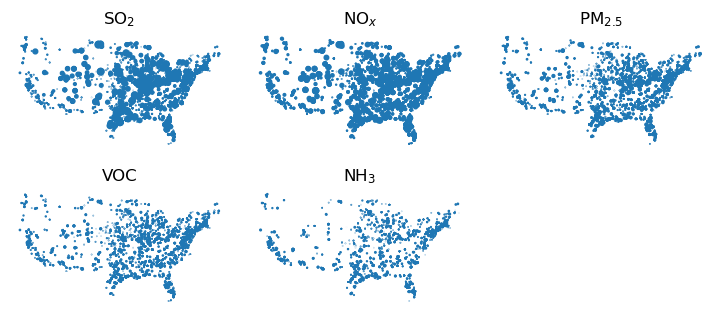

In [37]:

import matplotlib.pyplot as plt
%matplotlib inline

pols = ["SOx", "NOx", "PM2_5", "VOC", "NH3"]
pol_names = ["SO$_2$", "NO$_x$", "PM$_{2.5}$", "VOC", "NH$_3$"]

fig, axes = plt.subplots(figsize=(7, 3), nrows=2, ncols=3, sharex=True, sharey=True)
plt.subplots_adjust(left=0, bottom=0, right=1, top=1, wspace=0.1, hspace=0.1)

i = 0
for x in axes:
    for ax in x:
        if i < len(pols):
            emis.plot(ax=ax, markersize=emis[pols[i]]**0.5 / 5)
            ax.set_title(pol_names[i])
        ax.set_xticks([])
        ax.set_yticks([])
        ax.axis('off')
        i = i+1
plt.show()

In [39]:
emis.sum(axis=0)[["VOC", "NOx", "NH3", "SOx", "PM2_5"]]


/tmp/ipykernel_267013/846213535.py:1: FutureWarning: The default value of numeric_only in GeoDataFrame.sum is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  emis.sum(axis=0)[["VOC", "NOx", "NH3", "SOx", "PM2_5"]]


VOC      3.345280e+04
NOx      1.314463e+06
NH3      2.501248e+04
SOx      1.571217e+06
PM2_5    1.408227e+05
dtype: float64

In [40]:
output_variables = {
    'TotalPM25':'PrimaryPM25 + pNH4 + pSO4 + pNO3 + SOA',
    'deathsK':'(exp(log(1.06)/10 * TotalPM25) - 1) * TotalPop * 1.0465819687408728 * MortalityRate / 100000 * 1.025229357798165',
    'deathsL':'(exp(log(1.14)/10 * TotalPM25) - 1) * TotalPop * 1.0465819687408728 * MortalityRate / 100000 * 1.025229357798165',
}

resultsISRM = run_sr(emis, model="isrm", emis_units="tons/year", output_variables=output_variables)

Finished (570 seconds)                               


In [42]:
resultsAPSCA = run_sr(emis, model="apsca_q0", emis_units="tons/year", output_variables=output_variables)

Finished (303 seconds)                          


In [43]:
deaths = pd.DataFrame.from_dict({
    "Model": ["ISRM", "APSCA"],
    "Krewski Deaths": [resultsISRM.deathsK.sum(), resultsAPSCA.deathsK.sum()],
    "LePeule Deaths": [resultsISRM.deathsL.sum(), resultsAPSCA.deathsL.sum()],
})

deaths

,Model,Krewski Deaths,LePeule Deaths
0,ISRM,6928.959583,15623.924632
1,APSCA,6035.354385,13598.336851


In [44]:
vsl = 9.0e6

pd.DataFrame.from_dict({
    "Model": ["ISRM", "APSCA"],
    "Krewski Damages": deaths["Krewski Deaths"] * vsl,
    "LePeule Damages": deaths["LePeule Deaths"] * vsl,
})

,Model,Krewski Damages,LePeule Damages
0,ISRM,6.236064e+10,1.406153e+11
1,APSCA,5.431819e+10,1.223850e+11


/tmp/ipykernel_267013/289037637.py:5: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  cut = resultsISRM.TotalPM25.append(resultsAPSCA.TotalPM25, ignore_index=True).quantile(q)


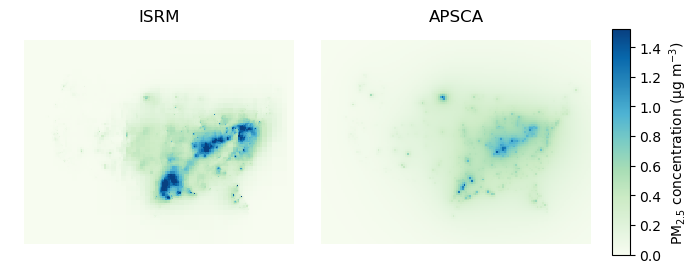

In [45]:
import numpy as np

q = 0.995 # We are going to truncate our results at the 99.5th percentile
          # to make the maps easier to interpret.
cut = resultsISRM.TotalPM25.append(resultsAPSCA.TotalPM25, ignore_index=True).quantile(q)


fig, axes = plt.subplots(figsize=(7, 2.5), nrows=1, ncols=2, sharex=True, sharey=True)
plt.subplots_adjust(left=0, bottom=0, right=1, top=1, wspace=0, hspace=0)

# Create the color bar.
im1 = axes[0].imshow(np.random.random((10,10)), vmin=0, cmap="GnBu", vmax=cut)
fig.subplots_adjust(right=0.85)
cbar_ax1 = fig.add_axes([0.86, 0.05, 0.025, 0.9])
c1 = fig.colorbar(im1, cax=cbar_ax1)
c1.ax.set_ylabel('PM$_{2.5}$ concentration (μg m$^{-3}$)')
axes[0].clear()

resultsISRM.plot(ax=axes[0], vmin=0, vmax=cut, cmap="GnBu", column="TotalPM25")
resultsAPSCA.plot(ax=axes[1], vmin=0, vmax=cut, cmap="GnBu", column="TotalPM25")

axes[0].axis('off')
axes[1].axis('off')

axes[0].set_title("ISRM")
axes[1].set_title("APSCA")

plt.show()

In [48]:
resultsAPSCA

,TotalPM25,deathsK,deathsL,geometry
0,0.005558,0.0,0.0,"POLYGON ((-2736000.000 -2088000.000, -2700000...."
1,0.005750,0.0,0.0,"POLYGON ((-2736000.000 -2052000.000, -2700000...."
2,0.005955,0.0,0.0,"POLYGON ((-2736000.000 -2016000.000, -2700000...."
3,0.006224,0.0,0.0,"POLYGON ((-2736000.000 -1980000.000, -2700000...."
4,0.006406,0.0,0.0,"POLYGON ((-2736000.000 -1944000.000, -2700000...."
...,...,...,...,...
16571,0.025337,0.0,0.0,"POLYGON ((2556000.000 1764000.000, 2592000.000..."
16572,0.024398,0.0,0.0,"POLYGON ((2556000.000 1800000.000, 2592000.000..."
16573,0.023451,0.0,0.0,"POLYGON ((2556000.000 1836000.000, 2592000.000..."
16574,0.022524,0.0,0.0,"POLYGON ((2556000.000 1872000.000, 2592000.000..."
